In [1]:
import torchvision.transforms as T

train_transform = T.Compose([
    T.Resize((224, 224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])

val_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225])
])


In [5]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

train_ds = ImageFolder("../data/classification_dataset/train", transform=train_transform)
val_ds   = ImageFolder("../data/classification_dataset/valid", transform=val_transform)
test_ds  = ImageFolder("../data/classification_dataset/test", transform=val_transform)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.535425].


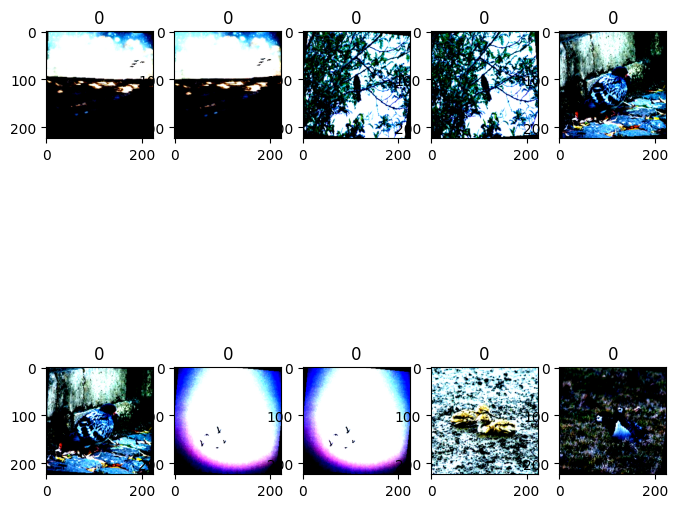

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))

for i in range(10):
     img, label = train_ds[i]
     plt.subplot(2, 5, i + 1)
     plt.imshow(img.permute(1, 2, 0))
     plt.title(label)
plt.show()



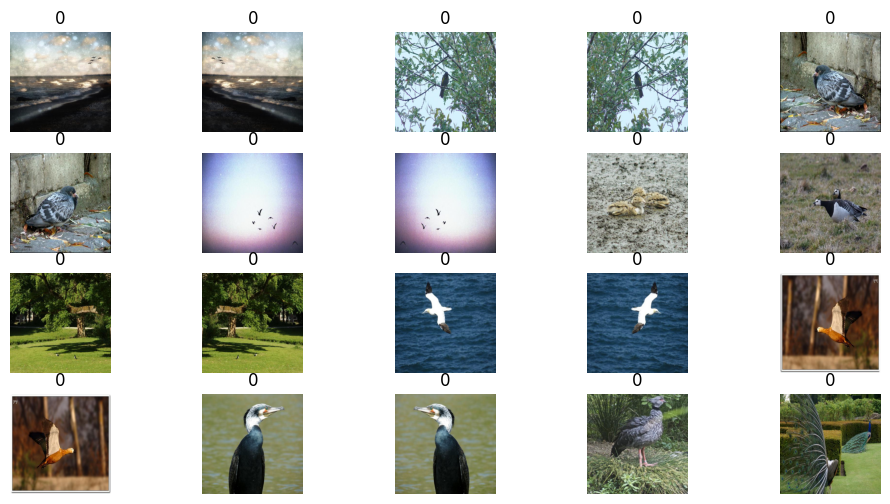

In [23]:
raw_ds = ImageFolder("../data/classification_dataset/train", transform=T.ToTensor())
plt.figure(figsize=(12, 6))

for i in range(20):
     plt.subplot(4, 5, i + 1)
     img, label = raw_ds[i]
     plt.imshow(img.permute(1, 2, 0))
     plt.title(label)
     plt.axis("off")
plt.show()

In [25]:
from collections import Counter

def count_classes(ds):
    labels = [label for _, label in ds]
    return Counter(labels)

print("Train:", count_classes(train_ds))
print("Val:", count_classes(val_ds))
print("Test:", count_classes(test_ds))

print("Classes:", train_ds.classes)


Train: Counter({0: 1414, 1: 1248})
Val: Counter({1: 225, 0: 217})
Test: Counter({0: 121, 1: 94})
Classes: ['bird', 'drone']


In [26]:
images, labels = next(iter(train_loader))
print("Batch shape:", images.shape)
print("Labels:", labels[:10])


Batch shape: torch.Size([32, 3, 224, 224])
Labels: tensor([0, 0, 1, 0, 0, 0, 0, 1, 1, 1])


In [27]:
images, labels = next(iter(train_loader))

print("Images shape:", images.shape)
print("Labels:", labels[:10])


Images shape: torch.Size([32, 3, 224, 224])
Labels: tensor([1, 0, 1, 1, 1, 0, 0, 0, 0, 0])


In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt


In [29]:
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 28 * 28, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)  # 2 classes: Bird, Drone
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = CustomCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


Using: cuda


In [31]:
train_losses = []
val_losses = []
train_acc = []
val_acc = []

EPOCHS = 10

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0
    correct = 0
    total = 0
    
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{EPOCHS}]")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    
    # Validation
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    
    val_losses.append(val_loss / len(val_loader))
    val_acc.append(val_correct / val_total)

    print(f"Epoch {epoch+1}: Train Acc={train_accuracy:.4f}, Val Acc={val_acc[-1]:.4f}")


Epoch [1/10]: 100%|██████████| 84/84 [00:30<00:00,  2.77it/s]


Epoch 1: Train Acc=0.7006, Val Acc=0.7738


Epoch [2/10]: 100%|██████████| 84/84 [00:25<00:00,  3.29it/s]


Epoch 2: Train Acc=0.7975, Val Acc=0.8009


Epoch [3/10]: 100%|██████████| 84/84 [00:24<00:00,  3.38it/s]


Epoch 3: Train Acc=0.8242, Val Acc=0.8258


Epoch [4/10]: 100%|██████████| 84/84 [00:24<00:00,  3.36it/s]


Epoch 4: Train Acc=0.8373, Val Acc=0.8439


Epoch [5/10]: 100%|██████████| 84/84 [00:24<00:00,  3.37it/s]


Epoch 5: Train Acc=0.8546, Val Acc=0.8235


Epoch [6/10]: 100%|██████████| 84/84 [00:25<00:00,  3.30it/s]


Epoch 6: Train Acc=0.8636, Val Acc=0.8371


Epoch [7/10]: 100%|██████████| 84/84 [00:25<00:00,  3.25it/s]


Epoch 7: Train Acc=0.8745, Val Acc=0.8416


Epoch [8/10]: 100%|██████████| 84/84 [00:24<00:00,  3.38it/s]


Epoch 8: Train Acc=0.9035, Val Acc=0.8439


Epoch [9/10]: 100%|██████████| 84/84 [00:26<00:00,  3.20it/s]


Epoch 9: Train Acc=0.9050, Val Acc=0.8100


Epoch [10/10]: 100%|██████████| 84/84 [00:24<00:00,  3.37it/s]


Epoch 10: Train Acc=0.9020, Val Acc=0.8462


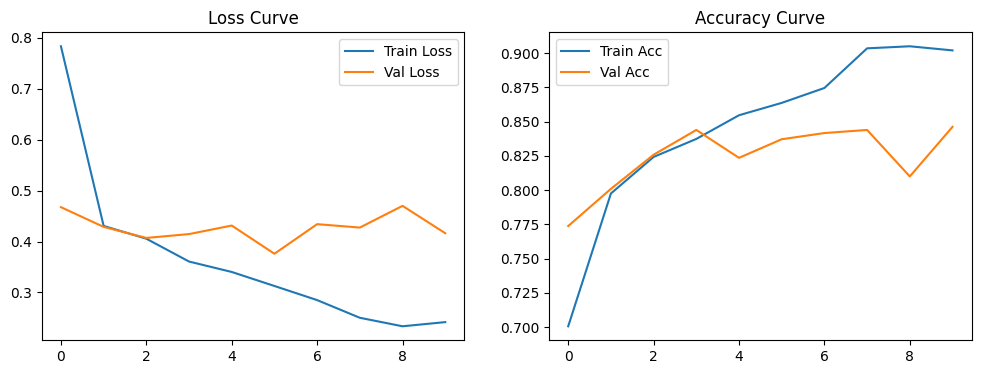

In [32]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend()
plt.title("Accuracy Curve")

plt.show()


In [34]:
torch.save(model.state_dict(), "../models/custom_cnn.pt")
print("Model saved as custom_cnn.pt")


Model saved as custom_cnn.pt


In [35]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {correct/total:.4f}")


Test Accuracy: 0.8884


In [36]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm import tqdm


In [37]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = models.mobilenet_v2(weights="IMAGENET1K_V1")


Using: cuda
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\vrajg/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth


100%|██████████| 13.6M/13.6M [00:00<00:00, 24.7MB/s]


In [38]:
for param in model.features.parameters():
    param.requires_grad = False


In [39]:
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, 2)   # 2 classes: bird & drone
)

model = model.to(device)


In [40]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)


In [41]:
EPOCHS = 5
train_acc = []
val_acc = []

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    running_loss = 0
    
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = correct / total
    train_acc.append(train_accuracy)

    # validation
    model.eval()
    v_correct, v_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)
    
    val_accuracy = v_correct / v_total
    val_acc.append(val_accuracy)

    print(f"Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


Epoch 1/5: 100%|██████████| 84/84 [00:24<00:00,  3.47it/s]


Train Acc: 0.8847, Val Acc: 0.9548


Epoch 2/5: 100%|██████████| 84/84 [00:22<00:00,  3.65it/s]


Train Acc: 0.9361, Val Acc: 0.9661


Epoch 3/5: 100%|██████████| 84/84 [00:22<00:00,  3.68it/s]


Train Acc: 0.9410, Val Acc: 0.9570


Epoch 4/5: 100%|██████████| 84/84 [00:22<00:00,  3.68it/s]


Train Acc: 0.9545, Val Acc: 0.9570


Epoch 5/5: 100%|██████████| 84/84 [00:22<00:00,  3.68it/s]


Train Acc: 0.9500, Val Acc: 0.9638


In [42]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Test Accuracy:", correct/total)


Test Accuracy: 0.9767441860465116


In [45]:
torch.save(model.state_dict(), "../models/mobilenet_phase1.pt")
print("Saved mobilenet_phase1.pt")


Saved mobilenet_phase1.pt


In [47]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

model = models.mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, 2)
)
model.load_state_dict(torch.load("../models/mobilenet_phase1.pt"))
model = model.to(device)


Using: cuda


In [48]:
# Unfreeze last 4 layers from features
for param in model.features[-1].parameters():
    param.requires_grad = True
for param in model.features[-2].parameters():
    param.requires_grad = True
for param in model.features[-3].parameters():
    param.requires_grad = True
for param in model.features[-4].parameters():
    param.requires_grad = True

# Classifier always trainable
for param in model.classifier.parameters():
    param.requires_grad = True


In [49]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.CrossEntropyLoss()


In [50]:
EPOCHS = 8
train_acc = []
val_acc = []

for epoch in range(EPOCHS):
    model.train()
    correct = 0
    total = 0
    running_loss = 0
    
    loop = tqdm(train_loader, desc=f"Fine-Tune Epoch {epoch+1}/{EPOCHS}")
    
    for images, labels in loop:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    
    train_accuracy = correct / total
    train_acc.append(train_accuracy)

    # validation
    model.eval()
    v_correct, v_total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            v_correct += (preds == labels).sum().item()
            v_total += labels.size(0)
    
    val_accuracy = v_correct / v_total
    val_acc.append(val_accuracy)

    print(f"[FineTune] Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")


Fine-Tune Epoch 1/8: 100%|██████████| 84/84 [00:32<00:00,  2.57it/s]


[FineTune] Train Acc: 0.9628, Val Acc: 0.9864


Fine-Tune Epoch 2/8: 100%|██████████| 84/84 [00:30<00:00,  2.77it/s]


[FineTune] Train Acc: 0.9884, Val Acc: 0.9729


Fine-Tune Epoch 3/8: 100%|██████████| 84/84 [00:30<00:00,  2.77it/s]


[FineTune] Train Acc: 0.9925, Val Acc: 0.9819


Fine-Tune Epoch 4/8: 100%|██████████| 84/84 [00:30<00:00,  2.76it/s]


[FineTune] Train Acc: 0.9917, Val Acc: 0.9842


Fine-Tune Epoch 5/8: 100%|██████████| 84/84 [00:30<00:00,  2.75it/s]


[FineTune] Train Acc: 0.9929, Val Acc: 0.9842


Fine-Tune Epoch 6/8: 100%|██████████| 84/84 [00:30<00:00,  2.75it/s]


[FineTune] Train Acc: 0.9959, Val Acc: 0.9819


Fine-Tune Epoch 7/8: 100%|██████████| 84/84 [00:30<00:00,  2.72it/s]


[FineTune] Train Acc: 0.9884, Val Acc: 0.9796


Fine-Tune Epoch 8/8: 100%|██████████| 84/84 [00:30<00:00,  2.76it/s]


[FineTune] Train Acc: 0.9970, Val Acc: 0.9842


In [51]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print("Final Test Accuracy:", correct/total)


Final Test Accuracy: 0.986046511627907


In [53]:
torch.save(model.state_dict(), "../models/best_classifier.pt")
print("Saved best_classifier.pt")


Saved best_classifier.pt


In [54]:
import torch
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [56]:
import torchvision.models as models

device = "cuda" if torch.cuda.is_available() else "cpu"

model = models.mobilenet_v2(weights="IMAGENET1K_V1")
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, 2)
)
model.load_state_dict(torch.load("../models/best_classifier.pt", map_location=device))
model = model.to(device)
model.eval()


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [57]:
all_labels = []
all_preds = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())


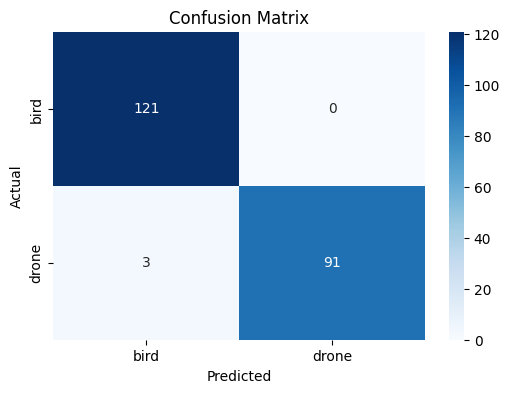

In [58]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['bird', 'drone'],
            yticklabels=['bird', 'drone'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [59]:
report = classification_report(all_labels, all_preds, target_names=['bird', 'drone'])
print(report)


              precision    recall  f1-score   support

        bird       0.98      1.00      0.99       121
       drone       1.00      0.97      0.98        94

    accuracy                           0.99       215
   macro avg       0.99      0.98      0.99       215
weighted avg       0.99      0.99      0.99       215



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.535425].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7240347..2.4831376].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5081482..2.5528543].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..1.76

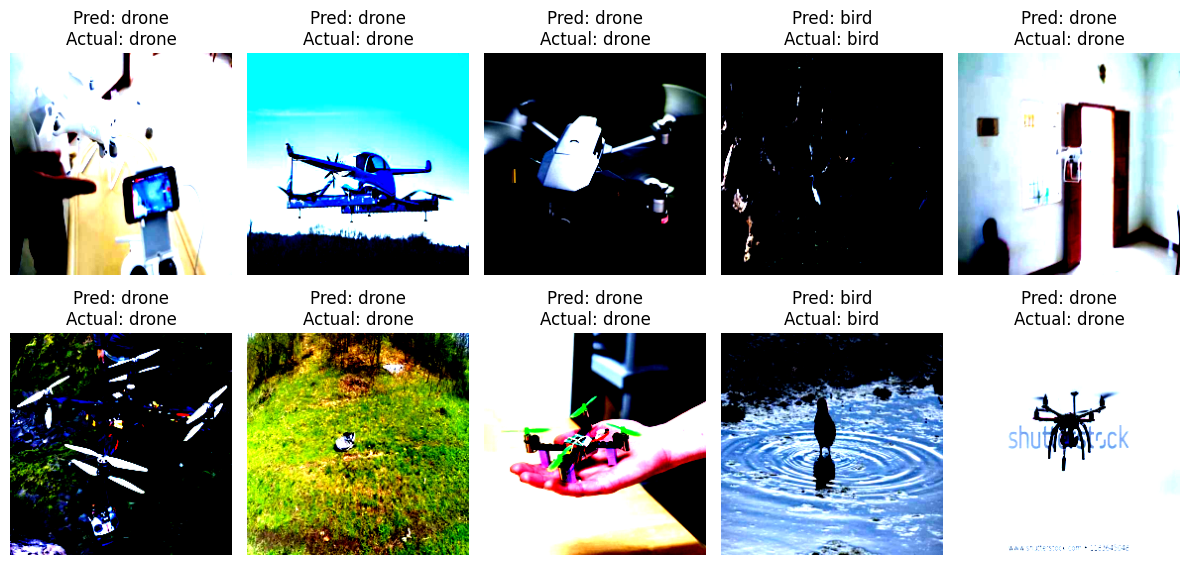

In [61]:
from torch.utils.data import Subset

indices = torch.randperm(len(test_ds))[:10]
subset = Subset(test_ds, indices)

plt.figure(figsize=(12, 6))

for i in range(10):
    img, label = subset[i]
    img_tensor = img.unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_tensor)
        _, pred = torch.max(output, 1)

    plt.subplot(2, 5, i+1)
    plt.imshow(img.permute(1,2,0))
    plt.title(f"Pred: {test_ds.classes[pred]}\nActual: {test_ds.classes[label]}")
    plt.axis("off")

plt.tight_layout()
plt.show()

